# Stocks Price Prediction

In [119]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
# function to download and save the raw data
def get_data(ticker, start, end):
    raw_data = yf.download(ticker, start, end)
    os.makedirs(f"../datasets/{ticker}", exist_ok=True)
    raw_data.to_csv(f"../datasets/{ticker}/raw.csv")
    return raw_data

In [121]:
ticker = "GOOG"
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)
print(start)

2015-09-09 00:00:00


In [122]:
# downloading the data
raw_data = get_data(ticker, start, end)
raw_data.head()

/tmp/ipykernel_16703/1084484216.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2015-09-09,30.427773,31.113083,30.272833,30.849885,34042000
2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000
2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000
2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000
2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000


In [123]:
# quick clean up
def clean_up(data):
    clean_data = data.copy()
    clean_data.columns = clean_data.columns.get_level_values(0)
    clean_data.columns.name = None
    clean_data.to_csv(f"../datasets/{ticker}/clean.csv")

clean_up(raw_data)

In [124]:
data = pd.read_csv(f"../datasets/{ticker}/clean.csv")
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-09,30.427773,31.113083,30.272833,30.849885,34042000
1,2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000
2,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000
3,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000
5,2015-09-16,31.582869,31.680698,31.401112,31.557543,25730000
6,2015-09-17,31.926523,32.323802,31.535200,31.672759,45494000
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000
8,2015-09-21,31.556051,31.608194,31.084281,31.504405,35770000
9,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000


In [125]:
data.shape

(2514, 6)

In [126]:
data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [127]:
data.duplicated().sum()

np.int64(0)

In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2514 non-null   object 
 1   Close   2514 non-null   float64
 2   High    2514 non-null   float64
 3   Low     2514 non-null   float64
 4   Open    2514 non-null   float64
 5   Volume  2514 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 118.0+ KB


In [129]:
data.tail(10)

,Date,Close,High,Low,Open,Volume
2504,2025-08-25,208.973221,210.901490,205.766081,206.815146,22788800
2505,2025-08-26,207.764297,208.273852,206.265637,208.183921,23051000
2506,2025-08-27,208.024078,209.382865,206.205696,206.275641,15249000
2507,2025-08-28,212.180344,212.709869,207.414614,207.654390,20915700
2508,2025-08-29,213.339310,215.147691,210.781598,211.081333,24682200
2509,2025-09-02,211.800705,212.179364,206.775198,208.803384,28900100
2510,2025-09-03,230.893631,231.593003,224.918960,226.277746,72250300
2511,2025-09-04,232.452240,232.562142,226.557499,229.949472,32196000
2512,2025-09-05,234.959991,235.919141,232.172490,232.452238,26127700
2513,2025-09-08,234.160004,238.399994,233.729996,235.789993,23104200


In [130]:
data.describe()

,Close,High,Low,Open,Volume
count,2514.000000,2514.000000,2514.000000,2514.000000,2.514000e+03
mean,92.621216,93.580157,91.620770,92.557378,2.956575e+07
std,48.223140,48.760894,47.671241,48.186284,1.417169e+07
min,29.542334,30.044399,29.268707,29.661023,6.809800e+06
25%,52.058872,52.671929,51.346376,52.094501,2.065125e+07
50%,75.555943,77.492687,75.004226,75.737964,2.613900e+07
75%,133.368324,134.884795,131.979327,133.317174,3.409300e+07
max,234.959991,238.399994,233.729996,235.789993,1.330780e+08


In [131]:
data["Date"] = pd.to_datetime(data["Date"])
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-09,30.427773,31.113083,30.272833,30.849885,34042000
1,2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000
2,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000
3,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000
5,2015-09-16,31.582869,31.680698,31.401112,31.557543,25730000
6,2015-09-17,31.926523,32.323802,31.535200,31.672759,45494000
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000
8,2015-09-21,31.556051,31.608194,31.084281,31.504405,35770000
9,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000


In [132]:
# creating subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.2
)

# candle stick chart
fig.add_trace(go.Candlestick(
    x = data["Date"],
    open = data["Open"],
    high = data["High"],
    low = data["Low"],
    close = data["Close"],
    name = "Price"
    ),
    row=1, col=1
)

# volume bars
fig.add_trace(go.Bar(
    x = data["Date"],
    y = data["Volume"],
    name = "volume",
    marker_color="#c1440e",
    opacity=1.0,
    ),
    row=2, col=1
)

# layout
fig.update_layout(
    title = "Candlesticks Chart With Volume",
    xaxis_rangeslider_visible = False,
    xaxis_title="Date",
    yaxis_title="Price",
    yaxis2_title="Volume",
    template="plotly_dark",
    showlegend = False,
    height=900
)

fig.show()

In [152]:
# adding log returns and pct returns
data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))
data['Pct_Returns'] = data['Close'].pct_change()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000,NaN,NaN
2,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000,0.007088,0.007113
3,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914,0.019094
5,2015-09-16,31.582869,31.680698,31.401112,31.557543,25730000,0.001322,0.001323
6,2015-09-17,31.926523,32.323802,31.535200,31.672759,45494000,0.010822,0.010881
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461,-0.021232
8,2015-09-21,31.556051,31.608194,31.084281,31.504405,35770000,0.009789,0.009837
9,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000,-0.020269,-0.020065
10,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000,-0.000530,-0.000530


In [153]:
data.isnull().sum()

Date           0
Close          0
High           0
Low            0
Open           0
Volume         0
Log_Returns    1
Pct_Returns    1
dtype: int64

In [154]:
data.shape

(2513, 8)

In [156]:
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000,NaN,NaN
2,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000,0.007088,0.007113
3,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914,0.019094
5,2015-09-16,31.582869,31.680698,31.401112,31.557543,25730000,0.001322,0.001323


In [157]:
data = data.dropna()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
2,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000,0.007088,0.007113
3,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914,0.019094
5,2015-09-16,31.582869,31.680698,31.401112,31.557543,25730000,0.001322,0.001323
6,2015-09-17,31.926523,32.323802,31.535200,31.672759,45494000,0.010822,0.010881
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461,-0.021232
8,2015-09-21,31.556051,31.608194,31.084281,31.504405,35770000,0.009789,0.009837
9,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000,-0.020269,-0.020065
10,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000,-0.000530,-0.000530
11,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000,0.005512,0.005527


In [158]:
data.shape

(2512, 8)

In [159]:
stats = data["Log_Returns"].describe()
skewness = data["Log_Returns"].skew()
kurtosis = data["Log_Returns"].kurtosis()

In [160]:

print("Summary Stats:\n", stats)
print("\nSkewness:", skewness)
print("Kurtosis:", kurtosis)

Summary Stats:
 count    2512.000000
mean        0.000807
std         0.018053
min        -0.117667
25%        -0.007191
50%         0.001375
75%         0.010051
max         0.099380
Name: Log_Returns, dtype: float64

Skewness: -0.18700701765335506
Kurtosis: 4.766093894149943


In [161]:
# stationarity check
result = adfuller(data['Log_Returns'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -16.915124114345957
p-value: 1.0037796893710277e-29
Critical Value 1%: -3.4329652692893364
Critical Value 5%: -2.8626954126892405
Critical Value 10%: -2.567385070816339


In [162]:
# volatility visualization
window = 21
data['Rolling_Vol'] = data['Log_Returns'].rolling(window).std()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,Rolling_Vol
2,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000,0.007088,0.007113,NaN
3,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043,NaN
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914,0.019094,NaN
5,2015-09-16,31.582869,31.680698,31.401112,31.557543,25730000,0.001322,0.001323,NaN
6,2015-09-17,31.926523,32.323802,31.535200,31.672759,45494000,0.010822,0.010881,NaN
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461,-0.021232,NaN
8,2015-09-21,31.556051,31.608194,31.084281,31.504405,35770000,0.009789,0.009837,NaN
9,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000,-0.020269,-0.020065,NaN
10,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000,-0.000530,-0.000530,NaN
11,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000,0.005512,0.005527,NaN


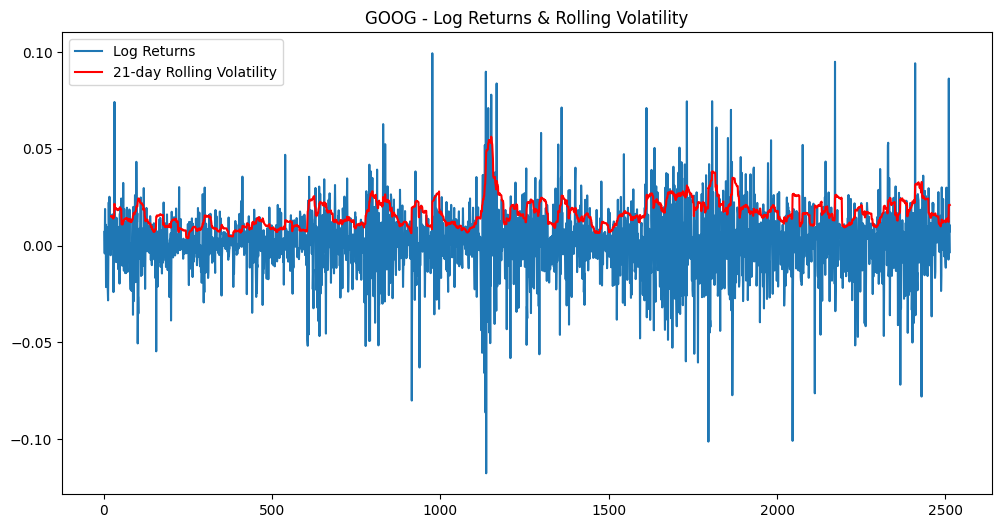

In [163]:
plt.figure(figsize=(12,6))
plt.plot(data['Log_Returns'], label='Log Returns')
plt.plot(data['Rolling_Vol'], label=f'{window}-day Rolling Volatility', color='red')
plt.legend()
plt.title(f"{ticker} - Log Returns & Rolling Volatility")
plt.show()

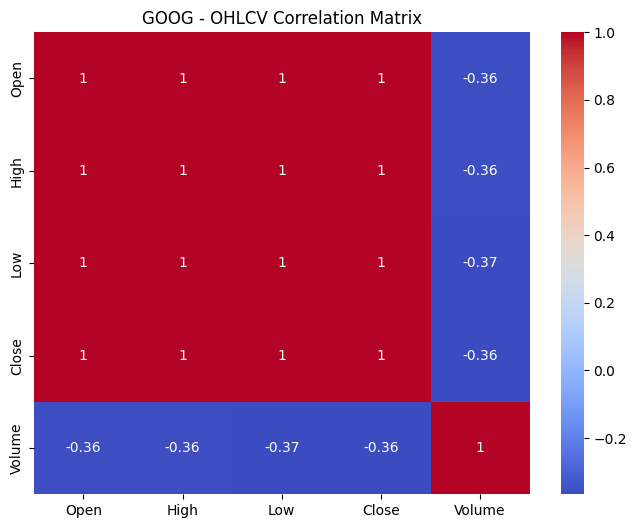

In [164]:
# correlation analysis
plt.figure(figsize=(8,6))
sns.heatmap(data[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title(f"{ticker} - OHLCV Correlation Matrix")
plt.show()

In [165]:
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,Rolling_Vol
2,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000,0.007088,0.007113,NaN
3,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043,NaN
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914,0.019094,NaN
5,2015-09-16,31.582869,31.680698,31.401112,31.557543,25730000,0.001322,0.001323,NaN
6,2015-09-17,31.926523,32.323802,31.535200,31.672759,45494000,0.010822,0.010881,NaN
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461,-0.021232,NaN
8,2015-09-21,31.556051,31.608194,31.084281,31.504405,35770000,0.009789,0.009837,NaN
9,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000,-0.020269,-0.020065,NaN
10,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000,-0.000530,-0.000530,NaN
11,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000,0.005512,0.005527,NaN


In [166]:
data = data.drop("Rolling_Vol", axis=1)
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
2,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000,0.007088,0.007113
3,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914,0.019094
5,2015-09-16,31.582869,31.680698,31.401112,31.557543,25730000,0.001322,0.001323
6,2015-09-17,31.926523,32.323802,31.535200,31.672759,45494000,0.010822,0.010881


In [148]:
data.shape

(2512, 8)

### Remark:
    So far in my data i have added the Log_Returns and Pct_Returns features
    in a few i will be adding other features such as macd, bollinger, rsi, sma/ema features

In [149]:
# simple and exponential moving averages function
def add_moving_averages(data, windows=(5, 10, 20, 50, 200)):
    data = data.copy()
    for window in windows:
        # simple moving average
        data[f"SMA_{window}"] = data["Close"].rolling(window=window, min_periods=1).mean()
        
        # exponential moving average
        data[f"EMA_{window}"] = data["Close"].ewm(span=window, adjust=False).mean()
    
    return data

In [150]:
# relative strength index function
def add_rsi(data, period=14):
    data = data.copy()
    delta = data["Close"].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0)

    ma_up = up.ewm(alpha=1 / period, adjust=False).mean()
    ma_down = down.ewm(alpha=1 / period, adjust=False).mean()

    rs = ma_up / ma_down
    data[f"RSI_{period}"] = 100 - (100 / (1 + rs))

    return data

In [168]:
# moving average convergence divergence function
def add_macd(data, fast=12, slow=26, signal=9):
    data = data.copy()
    ema_fast = data["Close"].ewm(span=fast, adjust=False).mean()
    ema_slow = data["Close"].ewm(span=slow, adjust=False).mean()

    data["MACD"] = ema_fast - ema_slow
    data["MACD_Signal"] = data["MACD"].ewm(span=signal, adjust=False).mean()
    data["MACD_Hist"] = data["MACD"] - data["MACD_Signal"]

    return data

In [169]:
# bollinger bands function
def add_bollinger_bands(data, window=20, n_std=2):
    data = data.copy()

    sma = data["Close"].rolling(window=window).mean()
    rstd = data["Close"].rolling(window=window).std()

    data[f"BB_MID_{window}"] = sma
    data[f"BB_UP_{window}"] = sma + n_std * rstd
    data[f"BB_LOW_{window}"] = sma - n_std * rstd

    return data